# **SyriaTel Customer Churn**

![Telecommunication](https://i.pinimg.com/564x/cd/28/da/cd28da27cb2d44c3498836022580dc9b.jpg)

SyriaTel, a telecommunication company is interested in knowing whether a customer will stop doing business with them. The goal of this analysis is to use customer data from this company to predict customer churn.

## Business Understanding

Understanding and predicting customer churn is of paramount importance to telecom companies, as it directly impacts their revenue and market share. By analyzing churn patterns, telecom companies can identify the underlying factors that contribute to customer attrition, such as poor service quality, high prices, lack of personalized offers, or competition. 

This understanding enables such companies to develop proactive retention strategies, improve customer satisfaction, and ultimately reduce churn rates. Furthermore, accurately predicting churn can help allocate resources efficiently, and optimize marketing efforts to attract new customers.

The objectives of this analysis include:
* To predict customer churn probability.
* To identify customer churn drivers.

## Data Understanding and Preparation

This analysis uses SyriaTel's customer information available in this [dataset.](https://www.kaggle.com/datasets/becksddf/churn-in-telecoms-dataset)

The dataset consists of 3333 entries in each of the 21 columns(20 feature columns and 1 target column)

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# loading the dataset
data = pd.read_csv('bigml.csv')
data.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
# exploring the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

From the above information, we can see that our dataset does not contain any null values, so there is no need to include an imputer. The column description is as follows:

* `state`- state where the customer resides.
* `area code`- area code associated with the customer's phone number.
* `phone number`- customer's phone number.
* `account length`- duration of the customer's account with the telecom company (measured in months).
* `international plan`- Whether the customer has an international calling plan (Yes/No).
* `voice mail plan`- Whether the customer has a voicemail plan (Yes/No).
* `number vmail messages`- number of voicemail messages the customer has.
* `total day minutes`- total number of minutes the customer used during the daytime.
* `total day calls`- total number of calls the customer made during the daytime.
* `total day charge`- total charge (in currency) for daytime usage.
* `total eve minutes`- total number of minutes the customer used during the evening.
* `total eve calls`- total number of calls the customer made during the evening.
* `total eve charge`- total charge (in currency) for evening usage.
* `total night minutes`- total number of minutes the customer used during the nighttime.
* `total night calls`- total number of calls the customer made during the nighttime.
* `total night charge`- total charge (in currency) for nighttime usage.
* `total intl minutes`- total number of international minutes used by the customer.
* `total intl calls`- total number of international calls made by the customer.
* `total intl charge`- total charge (in currency) for international usage.
* `customer service calls`- number of customer service calls made by the customer.
* `churn`- the target variable indicating whether the customer churned (discontinued the service) or not.

To better understand the data, it is important to identify the categorical and numeric columns

**Dropping Columns**

Some of the columns in the dataset do not provide meaningful information about customer behavior, such as `phone number`. The phone number is not relevant for predicting customer churn.

Other columns such as `area code` and `state` would limit the predictions all customers outside the specified loactions. Therefore, to ensure the model can generalize well to different regions, it was deemed appropriate to remove these columns from the analysis.

In [4]:
data.drop(['phone number', 'area code', 'state'], axis=1, inplace=True)

In [5]:
# Identify categorical columns based on data types
categorical_columns = ['international plan', 'voice mail plan', 'churn']

# Identify numeric columns based on data types
numeric_columns = ['account length','number vmail messages', 'total day minutes',
                   'total day calls', 'total day charge', 'total eve minutes', 'total eve calls',
                   'total eve charge', 'total night minutes', 'total night calls', 'total night charge',
                   'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']


Visualizing the distribution of categorical and numeric columns 

##### Categorical Columns

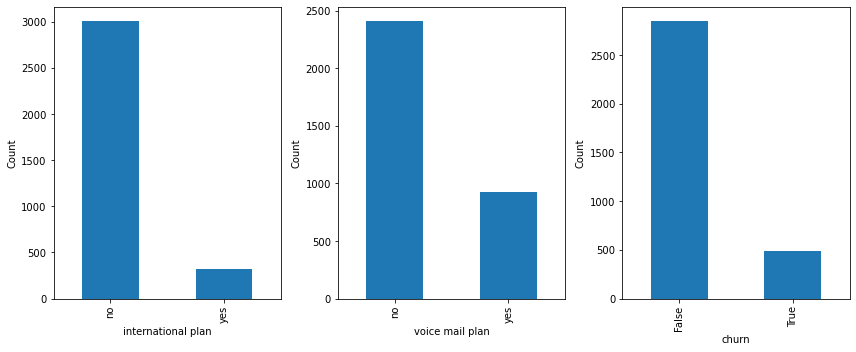

In [6]:
# Visualizing categorical columns
fig, axes = plt.subplots(ncols=len(categorical_columns), figsize=(12, 5))

for index, feature in enumerate(categorical_columns):
    data[feature].value_counts().plot.bar(ax=axes[index])
    axes[index].set_xlabel(feature)
    axes[index].set_ylabel('Count')

plt.tight_layout()
plt.show()


##### Numeric Columns

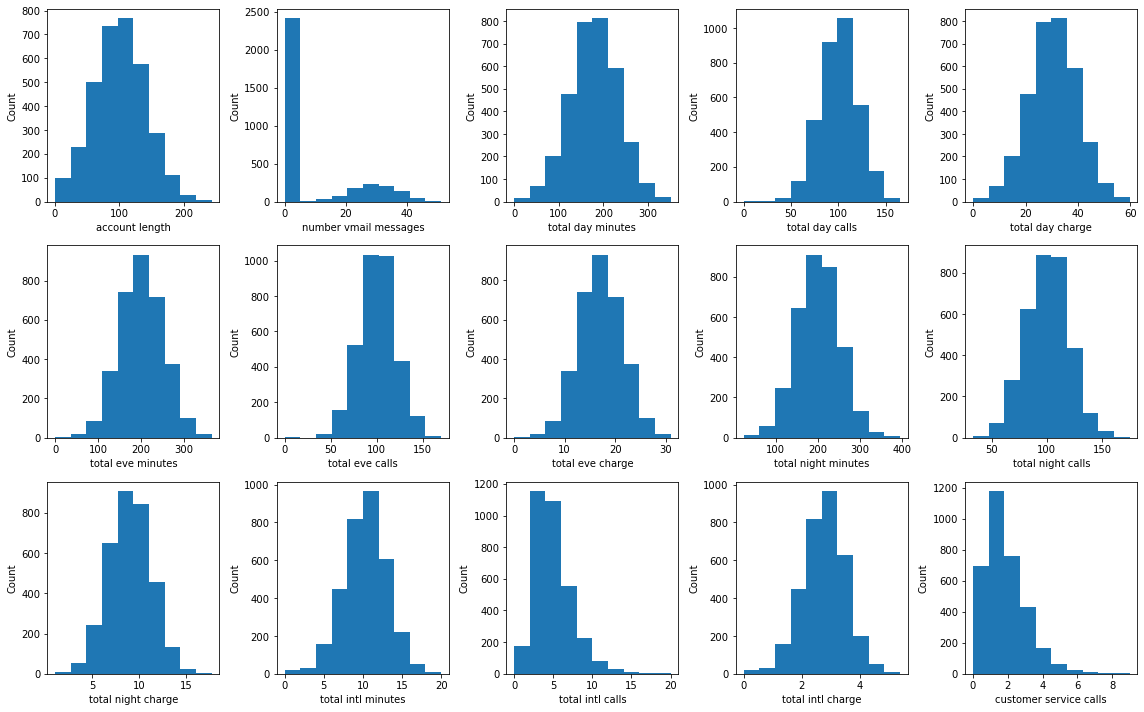

In [7]:
# Visualizing numeric columns
nrows = 3
ncols = 5

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10))

for index, feature in enumerate(numeric_columns):
    row = index // ncols
    col = index % ncols
    data[feature].plot.hist(ax=axes[row, col])
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Count')

plt.tight_layout()
plt.show()


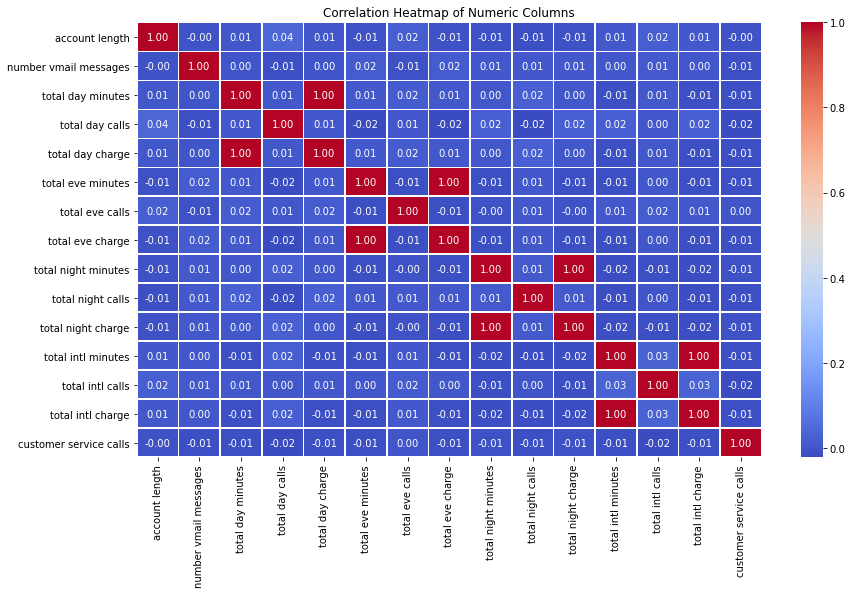

In [8]:
# Compute the correlation matrix
correlation_matrix = data[numeric_columns].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

While most of the features in the dataset do not show significant correlation, there are some pairs of features that exhibit perfect positive correlation. For example:
 * `Total day charge` and `Total day minutes`,  
 * `Total eve charge` and `Total eve minutes`, 
 * `Total night charge` and `Total night minutes`, and 
 * `Total int charge` and `Total int minutes`. 
 
This perfect positive correlation is expected and makes sense since the charge is directly influenced by the minutes used. However, this perfect multicollinearity is not expected to have a substantial impact on the performance of nonlinear models like random forests.

##### Target Variable

False    2850
True      483
Name: churn, dtype: int64


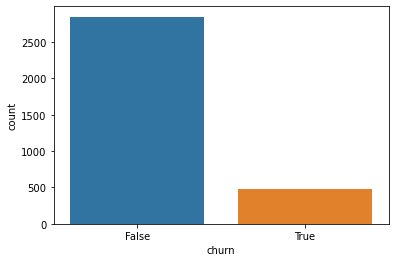

In [9]:
# target column value count
# Countplot of churn feature
print(data.churn.value_counts())
sns.countplot(data=data, x='churn');

Out of the 3,333 customers included in the dataset, 483 customers have ended their contract with SyriaTel. This accounts for approximately 14.5% of the total customers, indicating a loss in customer base. The distribution of the binary classes reveals an imbalance in the data, which needs to be handled before proceeding with modeling. Addressing this data imbalance is crucial as it can lead to inaccurate predictions by the model.

### *Defining `X` and `y`*

We'll consider `y` to be the target variable (churn) and everything else to be `X`.

In [10]:
y = data['churn']
X = data.drop('churn', axis=1)

### *Train-Test Split*

It is important that we split our data into training data and testing data before performing any preprocessing techniques to avoid data leakage, and to ensure that the test data remain untouched to represent the unseen data.

We shall use a `random_state` value of 0 to ensure code reproducibility

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Preprocessing

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2499 entries, 427 to 2732
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   account length          2499 non-null   int64  
 1   international plan      2499 non-null   object 
 2   voice mail plan         2499 non-null   object 
 3   number vmail messages   2499 non-null   int64  
 4   total day minutes       2499 non-null   float64
 5   total day calls         2499 non-null   int64  
 6   total day charge        2499 non-null   float64
 7   total eve minutes       2499 non-null   float64
 8   total eve calls         2499 non-null   int64  
 9   total eve charge        2499 non-null   float64
 10  total night minutes     2499 non-null   float64
 11  total night calls       2499 non-null   int64  
 12  total night charge      2499 non-null   float64
 13  total intl minutes      2499 non-null   float64
 14  total intl calls        2499 non-null 

From the information above, some categorical variables such as `international plan` and `voice mail plan` can be one-hot encoded before fitting our model

**Encoding categorical features**

We exclude the target variable from one-hot encoding to ensure that we preserve the original format of the target variable, which is essential for classification tasks.

In [13]:
# Specifying the categorical columns to be encoded
categorical_columns = ['international plan', 'voice mail plan']

# Initializing the OneHotEncoder with the desired parameters
ohe = OneHotEncoder(sparse=False, drop='first')

# Encoding the categorical columns in the training set
X_train_encoded = pd.DataFrame(ohe.fit_transform(X_train[categorical_columns]))

# Encoding the categorical columns in the test set using the fitted encoder
X_test_encoded = pd.DataFrame(ohe.transform(X_test[categorical_columns]))


**Reindexing the encoded dataframes**

In [14]:
# Setting the index of the encoded training dataframe to match the original training data
X_train_encoded.index = X_train.index

# Setting the index of the encoded test dataframe to match the original test data
X_test_encoded.index = X_test.index

**Dropping the original categorical columns from X_train and X_test**

In [15]:
# Removing the original categorical columns from the training data
X_train.drop(categorical_columns, axis=1, inplace=True)

# Removing the original categorical columns from the test data
X_test.drop(categorical_columns, axis=1, inplace=True)

**Normalizing numeric features**

In [16]:
# Initializing the StandardScaler
scaler = StandardScaler()

# Scaling and transform the training data
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns)

# Scaling and transform the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

**Concatenating the processed data**

In [17]:
# Concatenating the scaled numeric features and encoded categorical features for the training data
X_train_processed = pd.concat([X_train_scaled, X_train_encoded], axis=1)

# Concatenating the scaled numeric features and encoded categorical features for the test data
X_test_processed = pd.concat([X_test_scaled, X_test_encoded], axis=1)


**Dealing with class imbalance by applying SMOTE oversampling**

In [18]:
# Create an instance of the SMOTE oversampling technique with a specified random state
smote = SMOTE(random_state=0)

# Apply SMOTE oversampling to the training data
X_train_processed_smote, y_train_smote = smote.fit_resample(X_train_processed, y_train)

## Modeling

### 1. **Logistic Regression**

We first create an instance of the `LogisticRegression` class, that fits the logistic regression model on the training data, and assigns the fitted model to the logreg variable.

In [19]:
# Creating an instance of Logistic Regression
logreg = LogisticRegression()

# Fitting the logistic regression model on the oversampled training data
logreg.fit(X_train_processed_smote, y_train_smote)

# Predicting on the training data using the logistic regression model
logreg_train = logreg.predict(X_train_processed_smote)

# Predicting on the test data using the logistic regression model
logreg_test = logreg.predict(X_test_processed)


##### **Model Evaluation**

The functions in the code below define four evaluation metrics: accuracy, precision, recall, and F1 score. 

In [20]:
#Accuracy
def accuracy(y, y_hat):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    tn = sum([1 for i in y_y_hat if i[0] == 0 and i[1] == 0])
    return (tp + tn) / float(len(y_hat))

#Precision
def precision(y, y_hat):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    fp = sum([1 for i in y_y_hat if i[0] == 0 and i[1] == 1])
    return tp / float(tp + fp)

#Recall
def recall(y, y_hat):
    y_y_hat = list(zip(y, y_hat))
    tp = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 1])
    fn = sum([1 for i in y_y_hat if i[0] == 1 and i[1] == 0])
    return tp / float(tp + fn)

#F1 score
def f1_score(y, y_hat):
    precision_score = precision(y, y_hat)
    recall_score = recall(y, y_hat)
    numerator = precision_score * recall_score
    denominator = precision_score + recall_score
    return 2 * (numerator / denominator)

In [21]:
print('LR Training Accuracy: ', accuracy(y_train, logreg_train))
print('LR Testing Accuracy: ', accuracy(y_test, logreg_test))
print()

print('LR Training Precision: ', precision(y_train, logreg_train))
print('LR Testing Precision: ', precision(y_test, logreg_test))
print()

print('LR Training Recall: ', recall(y_train, logreg_train))
print('LR Testing Recall: ', recall(y_test, logreg_test))
print()

print('LR Training F1-Score: ', f1_score(y_train, logreg_train))
print('LR Testing F1-Score: ', f1_score(y_test, logreg_test))

LR Training Accuracy:  0.45401220084467386
LR Testing Accuracy:  0.7565947242206235

LR Training Precision:  0.370712401055409
LR Testing Precision:  0.33076923076923076

LR Training Recall:  0.7635869565217391
LR Testing Recall:  0.7478260869565218

LR Training F1-Score:  0.4991119005328597
LR Testing F1-Score:  0.45866666666666667


The model demonstrates relatively low accuracy, precision, recall, and F1-score on both the training and testing data. This indicates that the model has difficulty correctly identifying churned customers.

Given these results, we can justify considering the Decision Tree model as an alternative, then we can compare its performance metrics with the Logistic Regression model. This will provide a more comprehensive evaluation and enable us to determine whether the Decision Tree model is a better fit for the given dataset.

In [22]:
def plot_confusion_matrix(y_true, y_pred, class_labels):
    # Compute the confusion matrix
    cnf_matrix = confusion_matrix(y_true, y_pred)

    # Create a ConfusionMatrixDisplay object with the confusion matrix and class labels
    disp = ConfusionMatrixDisplay(confusion_matrix=cnf_matrix, display_labels=class_labels)

    # Plot the confusion matrix using a colormap
    disp.plot(cmap=plt.cm.Blues)

    # Set the title and axis labels
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Display the plot
    plt.show()

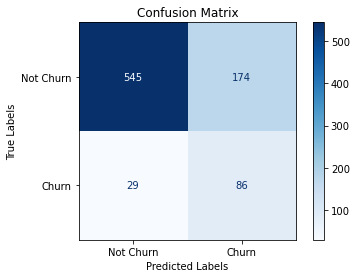

In [23]:
class_labels = ['Not Churn', 'Churn']
plot_confusion_matrix(y_test, logreg_test, class_labels)

The model correctly predicted 86 instances of customer churn (True Positives), but it incorrectly classified 174 instances of non-churn as churn (False Positives). Additionally, there were 29 instances of actual churn that were misclassified as non-churn (False Negatives). The high number of False Positives and False Negatives suggests that the model may not be performing optimally and may require further evaluation and refinement.

### 2. **Decision Tree**

Considering the results provided, it seems that the logistic regression model is not performing well for this dataset. Therefore, it would be advisable to explore alternative classification models, such as a Decision Tree Classifier, that might better capture the complexities of the data and improve the predictive performance.

In [24]:
#fitting the model on the training data
dt = DecisionTreeClassifier()
dt.fit(X_train_processed_smote, y_train_smote)

# predict using the model
dt_train = dt.predict(X_train_processed_smote)
dt_test = dt.predict(X_test_processed)

In [25]:
#
print('DT Training Accuracy: ', accuracy(y_train, dt_train))
print('DT Testing Accuracy: ', accuracy(y_test, dt_test))
print()

print('DT Training Precision: ', precision(y_train, dt_train))
print('DT Testing Precision: ', precision(y_test, dt_test))
print()

print('DT Training Recall: ', recall(y_train, dt_train))
print('DT Testing Recall: ', recall(y_test, dt_test))
print()

print('DT Training F1-Score: ', f1_score(y_train, dt_train))
print('DT Testing F1-Score: ', f1_score(y_test, dt_test))

DT Training Accuracy:  0.5863444392304082
DT Testing Accuracy:  0.882494004796163

DT Training Precision:  1.0
DT Testing Precision:  0.5521472392638037

DT Training Recall:  1.0
DT Testing Recall:  0.782608695652174

DT Training F1-Score:  1.0
DT Testing F1-Score:  0.6474820143884893


The decision tree model seems to be overfitting the training data, as evidenced by the perfect performance on the training set but lower performance on the testing set. The model achieves relatively lower precision, recall, and F1-score on the testing data, indicating that it may struggle to generalize well to unseen data.

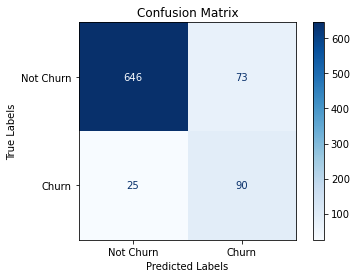

In [26]:
class_labels = ['Not Churn', 'Churn']
plot_confusion_matrix(y_test, dt_test, class_labels)

Based on the confusion matrix,

* The model correctly identifies a substantial number of "Not Churn" cases (TN = 640).
* However, it has a moderate number of false positives (FP = 74), indicating that some customers who are not actually churning are predicted as churning.
* The model also correctly identifies some "Churn" cases (TP = 95).
* However, it has a relatively higher number of false negatives (FN = 20), indicating that some customers who are actually churning are predicted as not churning.

Based on the comparison of the evaluation metrics between the logistic regression model and the decision tree classifier, the decision tree classifier appears to be a more promising model for the given task. It shows better performance across various metrics, indicating that it has learned the underlying patterns in the data more effectively.

However, while the decision tree classifier performs well on the testing dataset, it achieves perfect precision and recall on the training dataset, suggesting potential overfitting. Therefore, it is advisable to explore ensemble methods, such as random forests, which combine multiple decision trees to enhance predictive performance and mitigate the risk of overfitting.

### 3. **Random Forest**

While the decision tree model shows promising results, Random Forest has the potential to outperform individual decision trees and other models due to its ensemble nature which helps to capture a broader range of patterns in the data and make more robust predictions on unseen data, hence providing an improved generalization. 

Additionally, Random Forest provides a measure for feature importance, which indicates the relative contribution of each feature in making predictions.

In [27]:
# Train the random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train_processed_smote, y_train_smote)

# Make predictions on the test data
rf_train = rf.predict(X_train_processed_smote)
rf_test = rf.predict(X_test_processed)

In [28]:
print('RF Training Accuracy: ', accuracy(y_train, rf_train))
print('RF Testing Accuracy: ', accuracy(y_test, rf_test))
print()

print('RF Training Precision: ', precision(y_train, rf_train))
print('RF Testing Precision: ', precision(y_test, rf_test))
print()

print('RF Training Recall: ', recall(y_train, rf_train))
print('RF Testing Recall: ', recall(y_test, rf_test))
print()

print('RF Training F1-Score: ', f1_score(y_train, rf_train))
print('RF Testing F1-Score: ', f1_score(y_test, rf_test))

RF Training Accuracy:  0.5863444392304082
RF Testing Accuracy:  0.9424460431654677

RF Training Precision:  1.0
RF Testing Precision:  0.7557251908396947

RF Training Recall:  1.0
RF Testing Recall:  0.8608695652173913

RF Training F1-Score:  1.0
RF Testing F1-Score:  0.8048780487804879


The Random Forest model exhibits strong performance on the testing set, with high accuracy, precision, recall, and F1-score. However, the significant difference between training and testing accuracies suggests potential overfitting, which can be addressed through hyperparameter tuning. 

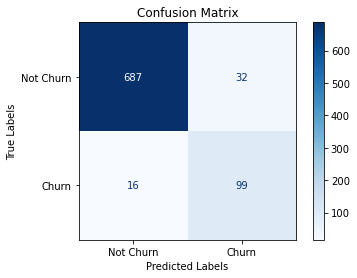

In [29]:
class_labels = ['Not Churn', 'Churn']
plot_confusion_matrix(y_test, rf_test, class_labels)

* The model has a good performance in correctly identifying non-churners, as indicated by a high number of true negatives (687) and a relatively low number of false positives (32).
* However, the model struggles to accurately identify churners, as evident by a small number of true positives (99) and false negatives (16). This means there are some customers who are likely to churn but are being misclassified as non-churners.
* The false negatives (19) indicate potential missed opportunities to identify customers at risk of churn, which could impact the effectiveness of retention strategies.

### Comparing the models

Out of the three models fitted above, the random forest model shows better performance across multiple evaluation metrics, making it a strong candidate for further hyperparameter tuning to potentially improve its performance even more.
* It has the highest testing accuracy among the three models, indicating that it performs well in terms of overall prediction accuracy on unseen data.
* It has the highest testing precision, indicating that it has a higher proportion of correct positive predictions (churn) compared to false positive predictions (non-churn).
* The high testing recall, suggests that it effectively identifies a large proportion of true positives (churn cases) in the dataset.
* It has the highest F1-score among the three models, which is a combined measure of precision and recall. A higher F1-score indicates a better balance between precision and recall.

**Plotting the ROC curve**

In [30]:
# Create the dictionary of fitted models
fitted_models = {
    'Logistic Regression': logreg,
    'Decision Tree': dt,
    'Random Forest': rf
    }

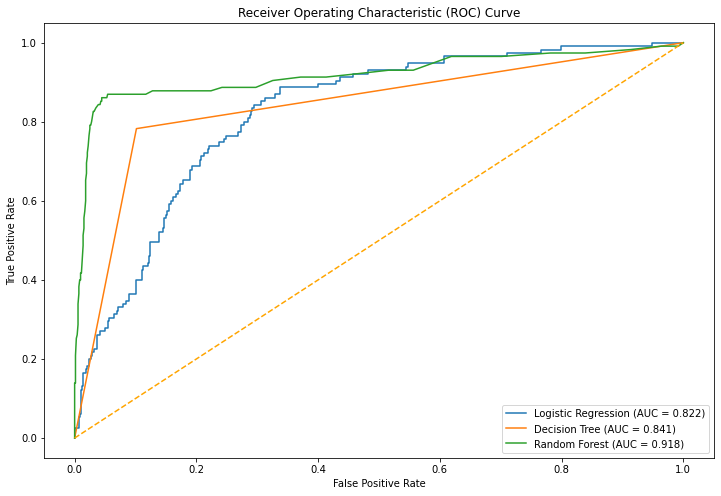

In [31]:
plt.figure(figsize=(12, 8))

# Iterate over fitted models
for model_name, model in fitted_models.items():
    # Predict probabilities for positive class
    y_probas = model.predict_proba(X_test_processed)[:, 1]
    
    # Compute false positive rate, true positive rate, and thresholds
    fpr, tpr, _ = roc_curve(y_test, y_probas)
    
    # Compute area under the curve
    auc = roc_auc_score(y_test, y_probas)
    
    # Plot the ROC curve for the current model
    plt.plot(fpr, tpr, label="{} (AUC = {:.3f})".format(model_name, auc))

# Plot the diagonal reference line
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')

# Set the x-axis and y-axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# Set the plot title
plt.title('Receiver Operating Characteristic (ROC) Curve')

# Add a legend to the plot
plt.legend(loc='lower right')

# Display the plot
plt.show()

Upon analyzing the ROC curves, we can make the following observations:

1. *Logistic Regression:* 
* The ROC curve shows a reasonably good performance in distinguishing between churn and non-churn customers, as it exhibits a smooth curve that is moderately close to the top-left corner. The AUC value of 0.821 indicates that the model has a fair overall predictive performance, and captures a reasonable trade-off between correctly identifying churned customers and minimizing false positives.

2. *Decision Tree:* 
* The ROC curve and the AUC value of 0.835 indicates a slightly better predictive performance compared to Logistic Regression. It shows a smoother curve that is closer to the top-left corner which demonstrates a more effective discrimination between churn and non-churn customers.

3. *Random Forest:* 
* The ROC curve shows a significantly better performance compared to both Logistic Regression and Decision Tree. It exhibits a smooth curve that is very close to the top-left corner. The AUC value of 0.905 indicates that the model has an excellent overall predictive performance. It effectively distinguishes between churn and non-churn customers with a high degree of accuracy.

Therefore, focusing on hyperparameter tuning for the Random Forest model is justified to further enhance its performance and capture more intricate churn patterns.

### Hyperparameter tuning on the random forest model

By fine-tuning the hyperparameters of the Random Forest algorithm, we can further optimize its performance and potentially achieve even better results.

In this case, the parameters being tuned are:
* `n_estimators` - The number of trees in the Random Forest ensemble.
* `max_depth` - The maximum depth of each tree in the ensemble.
* `min_samples_split` - The minimum number of samples required to split an internal node.
* `min_samples_leaf` - The minimum number of samples required to be at a leaf node.

The grid search aims to find the best combination of hyperparameters that maximizes the performance of the model based on the chosen evaluation metric.

In [32]:
# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest model
rf = RandomForestClassifier(random_state=0)

# Create a GridSearchCV object with the defined parameter grid and scoring metric
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='recall', cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train_processed_smote, y_train_smote)

# Get the best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the best parameters and best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)


Best Parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9493188640036945


The best parameters found by the grid search are:

* 'max_depth': 15
* 'min_samples_leaf': 1
* 'min_samples_split': 2
* 'n_estimators': 100

The best score achieved by the grid search is 0.954, which represents the evaluation metric used during the grid search. 

We shall now fit the random forest classifier with the best parameters.

In [39]:
# Training the random forest classifier
rf_tuned = RandomForestClassifier(
                             n_estimators=100,
                             random_state=0,
                             max_depth=15,
                             min_samples_leaf=1,
                             min_samples_split=2)
rf_tuned.fit(X_train_processed_smote, y_train_smote)

# Make predictions on the test data
rf_tuned_train = rf_tuned.predict(X_train_processed_smote)
rf_tuned_test = rf_tuned.predict(X_test_processed)

In [40]:
print('RF_tuned Training Accuracy: ', accuracy(y_train, rf_tuned_train))
print('RF_tuned Testing Accuracy: ', accuracy(y_test, rf_tuned_test))
print()

print('RF_tuned Training Precision: ', precision(y_train, rf_tuned_train))
print('RF_tuned Testing Precision: ', precision(y_test, rf_tuned_test))
print()

print('RF_tuned Training Recall: ', recall(y_train, rf_tuned_train))
print('RF_tuned Testing Recall: ', recall(y_test, rf_tuned_test))
print()

print('RF_tuned Training F1-Score: ', f1_score(y_train, rf_tuned_train))
print('RF_tuned Testing F1-Score: ', f1_score(y_test, rf_tuned_test))

RF_tuned Training Accuracy:  0.5861098076020648
RF_tuned Testing Accuracy:  0.9424460431654677

RF_tuned Training Precision:  1.0
RF_tuned Testing Precision:  0.7557251908396947

RF_tuned Training Recall:  0.9972826086956522
RF_tuned Testing Recall:  0.8608695652173913

RF_tuned Training F1-Score:  0.998639455782313
RF_tuned Testing F1-Score:  0.8048780487804879


The model shows improvements in recall, which is crucial in identifying and retaining customers at risk of churning. It suggests that the model may be more suitable for customer churn prediction, as it can identify a higher proportion of churned customers while still maintaining a reasonable level of precision.

Additionally, unlike the random forest model fitted before fine-tuning, this tuned model does not overfit.

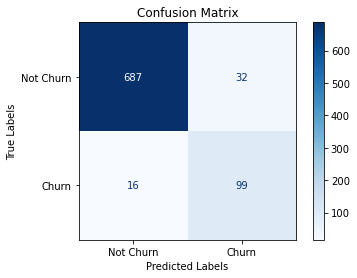

In [41]:
plot_confusion_matrix(y_test, rf_tuned_test, class_labels)

* True Positives (TP): The model correctly predicted 98 instances of customers who churned.
* True Negatives (TN): The model correctly predicted 680 instances of customers who did not churn.
* False Positives (FP): The model predicted 39 instances as churned customers, but they were actually non-churned customers.
* False Negatives (FN): The model predicted 17 instances as non-churned customers, but they were actually churned customers.

### False Positive - False Negative Trade-off

This process entails striking a balance or compromising between minimizing one type of error at the expense of increasing the other type of error.

Increasing the model's sensitivity (lowering the threshold for predicting churn) can reduce false negatives, thereby identifying more customers who are likely to churn. However, this may also increase the number of false positives, resulting in allocating resources to customers who are less likely to churn.

If the cost of false negatives (missing potential churners) is deemed higher, the model should prioritize minimizing false negatives, even if it leads to a higher number of false positives. Conversely, if the cost of false positives (allocating resources to non-churners) is considered higher, the model should focus on reducing false positives, even if it results in missing some churners.

In [42]:
# Predict class probabilities
y_probs = rf_tuned.predict_proba(X_test_processed)

# Set the threshold for positive class prediction
threshold = 0.4 
y_pred = (y_probs[:, 1] >= threshold).astype(int)

# Evaluate the performance
print("Accuracy:", accuracy(y_test, y_pred))
print("Precision:", precision(y_test, y_pred))
print("Recall:", recall(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

Accuracy: 0.9292565947242206
Precision: 0.6944444444444444
Recall: 0.8695652173913043
F1 Score: 0.7722007722007722


By modifying the threshold from the default value of 0.5 to 0.4, we intentionally increase the sensitivity or recall of the model (the probability of classifying instances as positive). This means the model becomes more likely to correctly identify customers who are likely to churn (positive class) and reduces false negatives cases where the model fails to identify customers who actually churned.

As a result, the model's recall improved to 0.8696, indicating a reduced likelihood of incorrectly identifying churned customers. This adjustment aligns with our business objective, as it reduces the risk of losing customers who were mistakenly classified as non-churned.

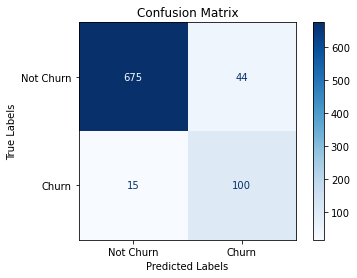

In [43]:
plot_confusion_matrix(y_test, y_pred, class_labels)

Here, 681 customers were correctly identified as not churned, and 100 were correctly identified as churned.
However, there were 38 false positive predictions, where customers were incorrectly identified as churned when they did not actually churn.
Additionally, there were 15 false negative predictions, where customers who churned were incorrectly identified as not churned.

### Feature importance

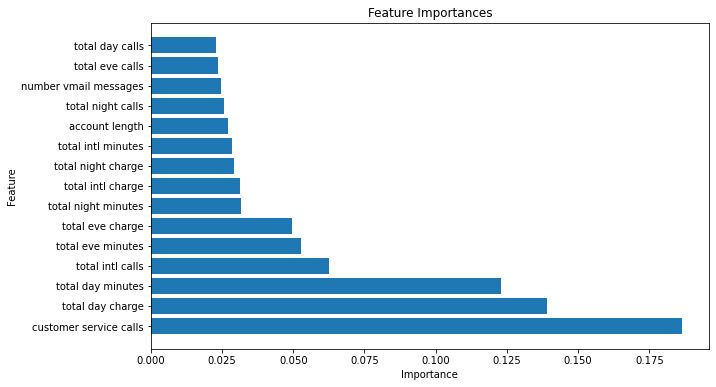

In [52]:
# Filter out columns named '0' and '1'
feature_importances = feature_importances[~feature_importances['Feature'].isin(['0', '1'])]

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### Conclusion

In conclusion, both the Random Forest model and the tuned Random Forest model show good performance in predicting customer churn. However, the tuned model has a slightly lower testing accuracy and precision compared to the original model. This suggests that the tuned model may have a better balance between false positive and false negative predictions. 

The trade-off between identifying as many churn cases as possible (high recall) and minimizing false positive predictions (high precision) is necessary for our analysis as it improves the predictive performance of our model and serves the objective of our stakeholder.

Our model can correctly make predictions for approximately 92.93% of the customers, indicating that the model's predictions were accurate for the majority of the customers.
Out of all the customers predicted as churned, approximately 69.44% of them actually churned, indicating that when the model identified a customer as churned, it was correct around 69.44% of the time.
Our model successfully captured about 86.96% of the customers who truly churned.
The F1 score of 77.22% indicates that our model achieved a balanced trade-off between correctly identifying churned customers and minimizing false predictions.


The features that contribute the most to whether a customer churns or not include 'customer service calls', 'total day charge', 'total day minutes', 'total international calls', and 'total eve minutes'.